# Exercise 2: GNNs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 709 kB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/c

## 2.1 - CiteSeer GCN

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Model Embeddings')

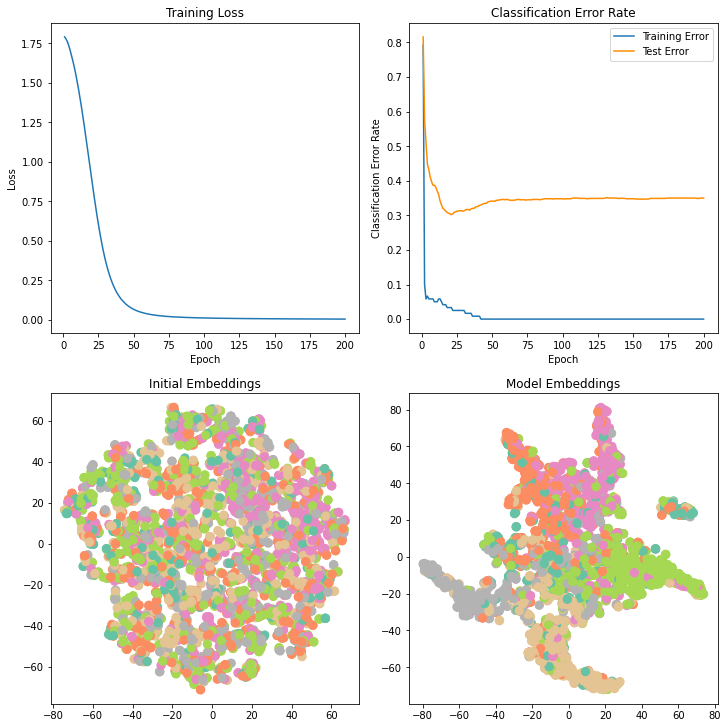

In [ ]:
# citeseer dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print(data)

# defining model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 64)
        self.conv2 = GCNConv(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainingLoss = []
trainingError = []
testError = []
for epoch in range(200):
    # training for this epoch
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    trainingLoss.append(loss.item())

    # calculate error rates
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    testError.append(1.0 - acc)

    pred = model(data).argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / int(data.train_mask.sum())
    trainingError.append(1.0 - acc)

# plotting
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 2, constrained_layout = True)

# training loss plot
axs[0,0].plot(np.arange(1,201), trainingLoss)
axs[0,0].set_ylabel('Loss')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_title('Training Loss')

# training error plot
axs[0,1].plot(np.arange(1,201), trainingError, label="Training Error")
axs[0,1].plot(np.arange(1,201), testError, color="darkorange", label="Test Error")
axs[0,1].set_ylabel('Classification Error Rate')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_title('Classification Error Rate')
axs[0,1].legend()

# plot the embeddings on the initialized model
dummyModel = GCN()
dummyOut = dummyModel(data)
emb = dummyOut
# node_type: (nNodes,). Entries are torch.int64 ranged from 0 to num_class - 1
node_type = data.y
z = TSNE(n_components=2).fit_transform(emb.detach().cpu().numpy())
axs[1,0].scatter(z[:, 0], z[:, 1], s=70, c=node_type, cmap="Set2")
axs[1,0].set_title('Initial Embeddings')

# layer node embeddings
# emb: (nNodes, hidden_dim)
model.eval()
emb = model(data)
# node_type: (nNodes,). Entries are torch.int64 ranged from 0 to num_class - 1
node_type = data.y
z = TSNE(n_components=2).fit_transform(emb.detach().cpu().numpy())
axs[1,1].scatter(z[:, 0], z[:, 1], s=70, c=node_type, cmap="Set2")
axs[1,1].set_title('Model Embeddings')

## 2.2 - GIN Model


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0.5, 1.0, 'Model Embeddings')

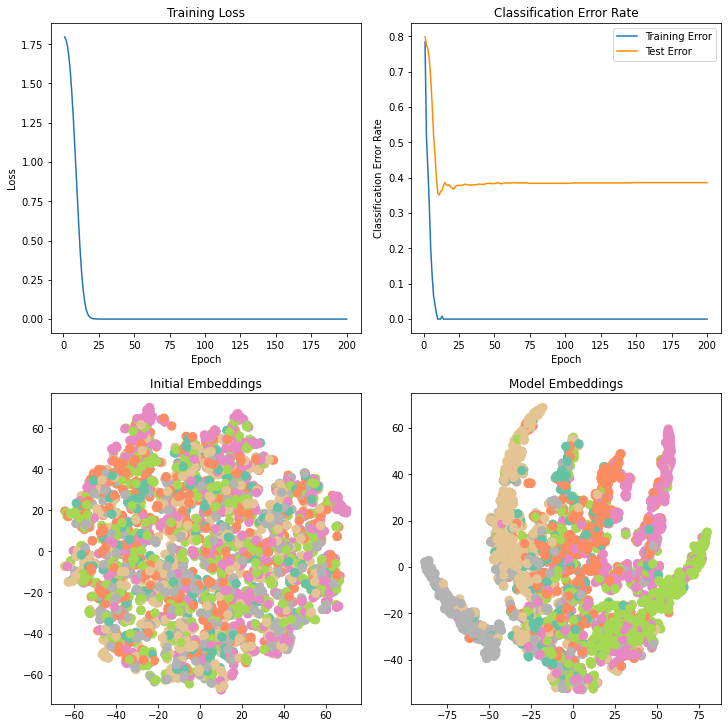

In [ ]:
# citeseer dataset
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]
print(data)

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_add_pool

class GIN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dataset.num_node_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        self.conv1 = GINConv(self.mlp)

        self.linearOut = nn.Linear(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.linearOut(x)

        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainingLoss = []
trainingError = []
testError = []
for epoch in range(200):
    # training for this epoch
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    trainingLoss.append(loss.item())

    # calculate error rates
    model.eval()
    pred = model(data).argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    testError.append(1.0 - acc)

    pred = model(data).argmax(dim=1)
    correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
    acc = int(correct) / int(data.train_mask.sum())
    trainingError.append(1.0 - acc)

plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(2, 2, constrained_layout = True)

# training loss plot
axs[0,0].plot(np.arange(1,201), trainingLoss)
axs[0,0].set_ylabel('Loss')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_title('Training Loss')

# training error plot
axs[0,1].plot(np.arange(1,201), trainingError, label="Training Error")
axs[0,1].plot(np.arange(1,201), testError, color="darkorange", label="Test Error")
axs[0,1].set_ylabel('Classification Error Rate')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_title('Classification Error Rate')
axs[0,1].legend()

# plot the embeddings on the initialized model 
dummyModel = GIN()
dummyOut = dummyModel(data)
emb = dummyOut
# node_type: (nNodes,). Entries are torch.int64 ranged from 0 to num_class - 1
node_type = data.y
z = TSNE(n_components=2).fit_transform(emb.detach().cpu().numpy())
axs[1,0].scatter(z[:, 0], z[:, 1], s=70, c=node_type, cmap="Set2")
axs[1,0].set_title('Initial Embeddings')

# layer node embeddings
# emb: (nNodes, hidden_dim)
model.eval()
emb = model(data)
# node_type: (nNodes,). Entries are torch.int64 ranged from 0 to num_class - 1
node_type = data.y
z = TSNE(n_components=2).fit_transform(emb.detach().cpu().numpy())
axs[1,1].scatter(z[:, 0], z[:, 1], s=70, c=node_type, cmap="Set2")
axs[1,1].set_title('Model Embeddings')

## 2.3 - Graph Classification on TUDataset

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2
==== train_dataset =====
MUTAG(150)
==== test_dataset =====
MUTAG(38)


Text(0.5, 1.0, 'Test Error Rate')

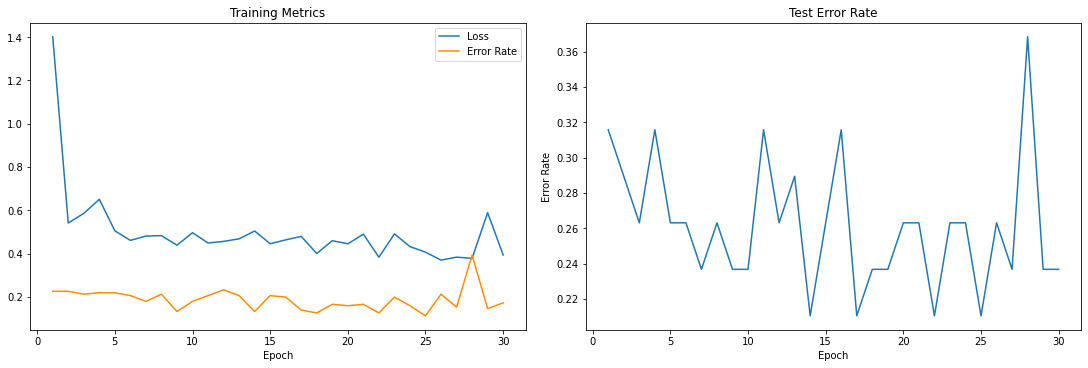

In [ ]:
class GraphGIN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(dataset.num_node_features, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        self.conv1 = GINConv(self.mlp)

        self.linearOut = nn.Linear(64, dataset.num_classes)

    def forward(self, x):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        # https://cs.stanford.edu/people/jure/pubs/gin-iclr19.pdf indicates that summation provides the most global information
        # x = global_mean_pool(x, batch)
        x = global_add_pool(x, batch)

        x = self.linearOut(x)

        return x

from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
# dataset = KarateClub(transform=NormalizeFeatures())
dataset = TUDataset(root='data/TUDataset', name='MUTAG', transform=NormalizeFeatures())
data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
train_dataset = dataset[: int(len(dataset) * 0.8)]
test_dataset = dataset[int(len(dataset) * 0.8): ]
trainloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print('==== train_dataset =====')
print(train_dataset)
print('==== test_dataset =====')
print(test_dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphGIN().to(device)
# data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainingLoss = []
trainingError = []
testError = []
for epoch in range(30):
    # training for this epoch
    model.train()
    # iterate over each batch
    epochLoss = 0.0
    for data in trainloader:
      optimizer.zero_grad()
      out = model(data)
      loss = F.cross_entropy(out, data.y)
      loss.backward()
      optimizer.step()
      epochLoss += loss.item()
    trainingLoss.append(epochLoss / len(trainloader))
    # calculate error rates
    model.eval()
    incorrects = 0
    for data in trainloader:
      pred = model(data).argmax(dim=1)
      incorrects += int((pred != data.y).sum())
    trainingError.append((incorrects / len(trainloader.dataset)))

    incorrects = 0
    for data in testloader:
      pred = model(data).argmax(dim=1)
      incorrects += int((pred != data.y).sum())
    testError.append((incorrects / len(testloader.dataset)))

plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2, constrained_layout = True)

# training loss plot
# twin1 = axs[0].twinx()
axs[0].plot(np.arange(1,31), trainingLoss, label="Loss")
axs[0].plot(np.arange(1,31), trainingError,color="darkorange", label="Error Rate")
axs[0].set_xlabel('Epoch')
axs[0].set_title('Training Metrics')
axs[0].legend()

# training error plot
axs[1].plot(np.arange(1,31), testError)
axs[1].set_ylabel('Error Rate')
axs[1].set_xlabel('Epoch')
axs[1].set_title('Test Error Rate')

## 2.4 - Minibatching

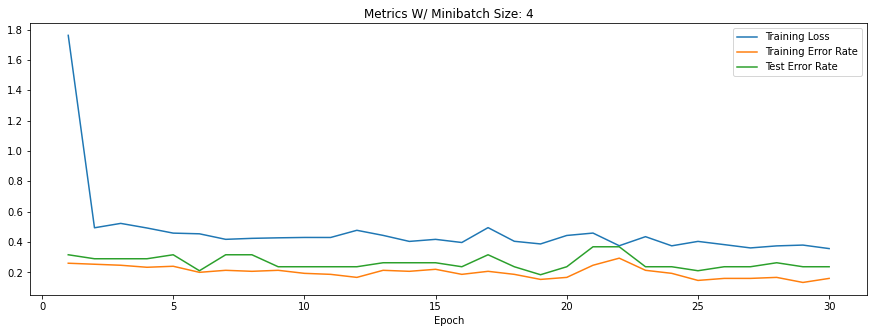

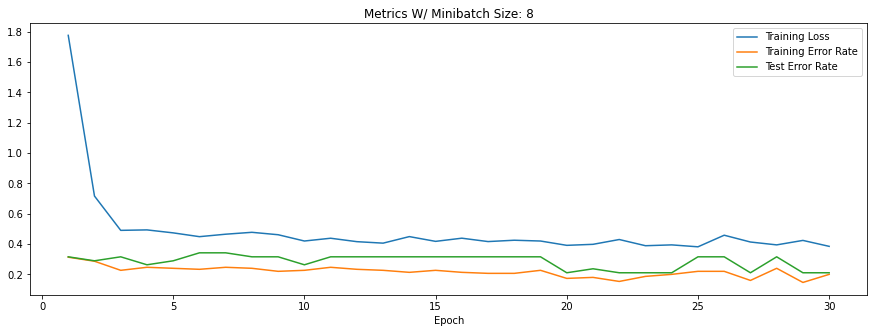

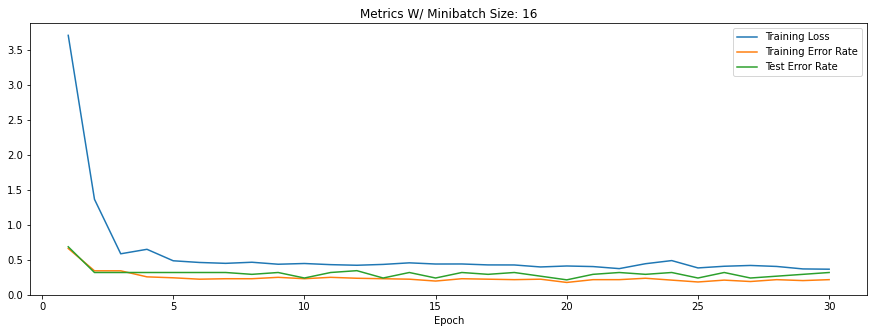

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.loader import DataLoader
# dataset = KarateClub(transform=NormalizeFeatures())

batchMetrics = []
for batchSize in [4,8,16]:
  dataset = TUDataset(root='data/TUDataset', name='MUTAG', transform=NormalizeFeatures())
  data = dataset[0]
  train_dataset = dataset[: int(len(dataset) * 0.8)]
  test_dataset = dataset[int(len(dataset) * 0.8): ]
  trainloader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
  testloader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GraphGIN().to(device)
  # data = dataset[0].to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  # criterion = torch.nn.CrossEntropyLoss()
  criterion = F.cross_entropy

  trainingLoss = []
  trainingError = []
  testError = []
  for epoch in range(30):
      # training for this epoch
      model.train()
      # iterate over each batch
      epochLoss = 0.0
      for data in trainloader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        epochLoss += loss.item()
      trainingLoss.append(epochLoss/len(trainloader))

      # calculate error rates
      model.eval()
      incorrects = 0
      for data in trainloader:
        pred = model(data).argmax(dim=1)
        incorrects += int((pred != data.y).sum())
      trainingError.append((incorrects / len(trainloader.dataset)))

      incorrects = 0
      for data in testloader:
        pred = model(data).argmax(dim=1)
        incorrects += int((pred != data.y).sum())
      testError.append((incorrects / len(testloader.dataset)))

  plt.rcParams["figure.figsize"] = (15,5)
  fig, axs = plt.subplots()

  # training loss plot
  # twin1 = axs.twinx()
  axs.plot(np.arange(1,31), trainingLoss, label="Training Loss")
  axs.plot(np.arange(1,31), trainingError, label="Training Error Rate")
  axs.plot(np.arange(1,31), testError, label="Test Error Rate") 
  # twin1.plot(np.arange(1,31), trainingError, label="Training Error Rate")
  # twin1.plot(np.arange(1,31), testError, label="Test Error Rate")
  axs.set_xlabel('Epoch')
  axs.set_title(f'Metrics W/ Minibatch Size: {batchSize}')
  axs.legend()